This notebook extracts well-tagged posts and splits them over chunks no more than 300 words, trying to preserve paragraph structure.

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from pandas import DataFrame,Series
import seaborn as sns
from tqdm.auto import tqdm
import json

from src.parsing import read_post_data

sns.set_theme(style="whitegrid")
tqdm.pandas()

In [3]:
data = read_post_data('./data/posts.csv')
data = data[(data.tags.map(len) > 4) & (data.tags.map(len) < 10)]
data = data[data.htmlBody.notna()]
data.shape

(1720, 14)

In [4]:
import html2text

h2t = html2text.HTML2Text()
h2t.ignore_emphasis = True
h2t.ignore_images = True
h2t.ignore_links = True
h2t.ignore_tables = True
h2t.body_width = None

In [5]:
data['body'] = data.htmlBody.progress_map(h2t.handle).map(str.strip)
data = data[data['body'].map(len) > 50]

  0%|          | 0/1720 [00:00<?, ?it/s]

In [6]:
import re
from nltk.tokenize import word_tokenize, sent_tokenize

def extract_paragraphs(text:str):
    """
    Extracts paragraphs from text. Designed for texts extracted with html2text.
    Args:
        text (str): markdown-like text without emphasis, images or tables
    """
    LIST_REG = re.compile(r"^ *([*-]+|\d+\.)")
    header_level = 0
    text_parts = []
    for line in text.splitlines():
        if len(line.strip()) == 0:
            continue

        if line.startswith("#"):
            header_level = len(line) - len(line.lstrip("#"))
            line = line.lstrip("#").strip()
            text_parts.append((header_level, line, "HEAD"))
            continue

        if LIST_REG.match(line):
            offset = len(line) - len(LIST_REG.sub("", line))
            # line = LIST_REG.sub("", line).strip()
            text_parts.append((header_level + offset, line.strip(), "LIST"))
            continue

        text_parts.append((header_level, line.strip(), "TEXT"))

    text_parts = DataFrame(text_parts, columns=["level", "text", "type"])
    text_parts['n_words'] = text_parts.text.map(word_tokenize).map(len)
    return text_parts


def split_long_paragraphs(paragraphs:DataFrame, max_n_words:int):
    if paragraphs.n_words.max() <= max_n_words:
        return paragraphs
    
    rows = []
    for _,row in paragraphs.iterrows():
        if row.n_words < max_n_words:
            rows.append(dict(row))
            continue
        
        sents = sent_tokenize(row.text) # It's not perfect but shouldn't have major impact (TODO: train tokenizer first)
        rows.extend([{"level": row.level + 1, "text": s, "type": "SENTENCE", "n_words": len(word_tokenize(s))} for s in sents])
    return DataFrame(rows)


def collapse_paragraphs(level_paragraphs:DataFrame, max_n_words:int):
    texts = []
    n_words_all = []
    n_words = 0
    text = []
    for t,n in zip(level_paragraphs.text, level_paragraphs.n_words):
        if n + n_words < max_n_words:
            text.append(t)
            n_words += n
            continue

        if n_words > 0:
            if n_words > max_n_words: # last text was too long
                print(f"Warning: paragraph too long ({n_words} words): {text}")
            texts.append("\n".join(text))
            n_words_all.append(n_words)

        text = [t]
        n_words = n
        continue

    if n_words > 0:
        if n_words > max_n_words: # last text was too long
            print(f"Warning: paragraph too long ({n_words} words): {text}")
        texts.append("\n".join(text))
        n_words_all.append(n_words)
    return DataFrame({"level": level_paragraphs.level.values[0], "text": texts, "type": "COLLAPSED", "n_words":n_words_all})


def collapse_paragraphs_iteratively(paragraphs, max_n_words:int):
    # Split by sequential levels
    # TODO: Ideally, also need to split by type here
    seq_levels = paragraphs.level.diff().fillna(0).map(bool).cumsum()
    pars_per_seq_level = paragraphs.groupby(seq_levels).apply(lambda x: [x]).map(lambda x: x[0]).values

    # collapse paragraphs
    pars_collapsed = []
    for pars in pars_per_seq_level:
        pars_col = collapse_paragraphs(pars, max_n_words)
        if (pars_col.shape[0] == 1) and (len(pars_collapsed) > 0):
            pars_collapsed[-1] = pd.concat([
                pars_collapsed[-1].iloc[:-1], 
                collapse_paragraphs(
                    pd.concat([pars_collapsed[-1].iloc[-1:], pars_col]), 
                    max_n_words
                )
            ])
        else:
            pars_collapsed.append(pars_col)
    return pd.concat(pars_collapsed)

In [7]:
data['paragraphs'] = data.body.progress_map(extract_paragraphs)

  0%|          | 0/1719 [00:00<?, ?it/s]

In [8]:
max_n_words = 300
data['paragraphs'] = data.paragraphs.progress_map(lambda p: split_long_paragraphs(p, max_n_words=max_n_words))

  0%|          | 0/1719 [00:00<?, ?it/s]

In [9]:
data['paragraphs_split'] = data.paragraphs.progress_map(lambda x: collapse_paragraphs_iteratively(x, max_n_words=max_n_words))

  0%|          | 0/1719 [00:00<?, ?it/s]

In [22]:
par_split_df = pd.concat([
    DataFrame({'postId': pid, 'tags': ";".join(r.tags), 'text': r.paragraphs_split.text.values}) 
    for pid,r in data.iterrows()
], ignore_index=True)
par_split_df.shape

(26953, 3)

In [11]:
data.to_pickle('./cache/posts_paragraphs.pkl')

In [23]:
par_split_df.to_csv('./cache/par_split_df.csv', index=False)

Trining of SBERT happens on Google Colab, so it's extracted to a separate notebook.

In [81]:
np.random.seed(42)
all_posts = par_split_df.postId.unique()
dev_posts = np.random.choice(all_posts, size=int(all_posts.size * 0.1), replace=False)
train_pars = par_split_df[~par_split_df.postId.isin(dev_posts)]
dev_pars = par_split_df[par_split_df.postId.isin(dev_posts)]
# train_pars, dev_pars = [df.copy().sample(n=500, random_state=42).reset_index(drop=True) for df in [train_pars, dev_pars]]

# for df in [train_pars, dev_pars]:
#     df['tags'] = df['tags'].map(lambda x: x.split(";")).map(set)

In [271]:
def jaccard_similarity(a:set, b:set):
    return len(a & b) / len(a | b)


def extract_paired_posts(post_id:str, selected_sims:np.ndarray, tags_per_post:Series, n_texts_per_post:int=1):
    t1 = tags_per_post[post_id]
    sims = tags_per_post.map(lambda t2: jaccard_similarity(t1, t2))
    freqs = [(1 - np.abs(sims - s)) ** 30 for s in selected_sims] # 30 is a severe penalty for distance. Adjusts for class imbalance.
    sel_posts = np.concatenate([
        np.random.choice(fs.index.values, p=(fs.values / fs.sum()), size=n_texts_per_post, replace=True) 
        for fs in freqs
    ])

    return sel_posts, sims[sel_posts].values


def extract_text_distance_pairs(df:DataFrame, tags_per_post:Series, n_pairs_per_text:int, n_texts_per_post:int=1):
    selected_sims = np.linspace(0, 1, n_pairs_per_text)

    texts_per_post = df.text.groupby(df.postId).apply(np.array)
    tags_per_post = tags_per_post[texts_per_post.index]
    texts_per_post = dict(texts_per_post)

    pair_dfs = []
    for pid,texts in tqdm(texts_per_post.items(), total=len(texts_per_post)):
        src_texts = np.random.choice(texts, size=(n_texts_per_post * n_pairs_per_text), replace=True)
        dst_pids, dst_sims = extract_paired_posts(
            pid, selected_sims=selected_sims, tags_per_post=tags_per_post, 
            n_texts_per_post=n_texts_per_post
        )
        dst_texts = np.concatenate([np.random.choice(texts_per_post[pid], size=1, replace=True) for pid in dst_pids])
        pair_dfs.append(DataFrame({'src_text': src_texts, 'dst_text': dst_texts, 'src_post_id': pid, 'dst_post_id': dst_pids, 'sims': dst_sims}))
    
    pair_df = pd.concat(pair_dfs, ignore_index=True)
    pair_df = pair_df[~pair_df[['src_text', 'dst_text']].duplicated()].reset_index(drop=True)
    return pair_df

In [250]:
# n_texts_per_post = 2
# n_pairs_per_text = 8
# selected_sims = np.linspace(0, 1, n_pairs_per_text)
tags_per_post = data.tags[all_posts].map(set)

In [279]:
train_pair_df = extract_text_distance_pairs(train_pars, tags_per_post, n_pairs_per_text=11, n_texts_per_post=10)
train_pair_df.shape

  0%|          | 0/1548 [00:00<?, ?it/s]

(141008, 5)

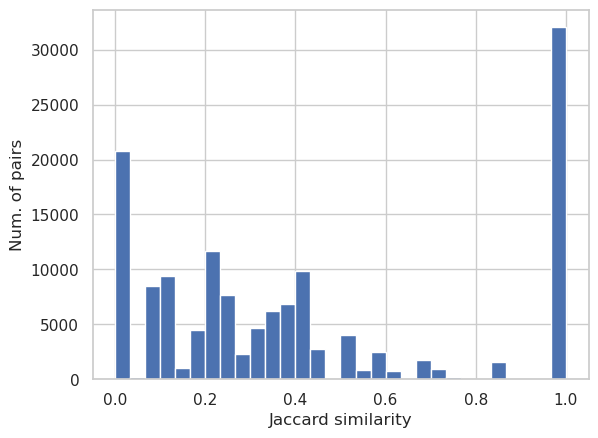

In [283]:
train_pair_df.sims.hist(bins=30);
plt.xlabel('Jaccard similarity'); plt.ylabel('Num. of pairs');

In [280]:
dev_pair_df = extract_text_distance_pairs(dev_pars, tags_per_post, n_pairs_per_text=11, n_texts_per_post=2)
dev_pair_df.shape

  0%|          | 0/171 [00:00<?, ?it/s]

(3415, 5)

In [284]:
train_pair_df.to_csv('./cache/train_pair_df.csv', index=False)
dev_pair_df.to_csv('./cache/dev_pair_df.csv', index=False)

In [274]:
# import csv
# from itertools import combinations

# def save_text_pairwise_distances_full(df:DataFrame, path:str):
#     with open(path, 'w') as f:
#         writer = csv.writer(f)
#         writer.writerow(['i1', 'i2', 'text1', 'text2', 'distance'])

#         for i1,i2 in tqdm(combinations(df.index.values, 2), total=(df.shape[0] * (df.shape[0] - 1) // 2)):
#             t1 = df.text.values[i1]
#             t2 = df.text.values[i2]
#             tags1 = df.tags.values[i1]
#             tags2 = df.tags.values[i2]
#             dist = 1 - len(tags1 & tags2) / len(tags1 | tags2)

#             writer.writerow([i1, i2, t1, t2, dist])

In [77]:
# save_text_pairwise_distances(train_pars, './cache/train_pairs.csv')

  0%|          | 0/124750 [00:00<?, ?it/s]

In [78]:
# save_text_pairwise_distances(dev_pars, './cache/dev_pairs.csv')

  0%|          | 0/124750 [00:00<?, ?it/s]

TODO:
- For each text take 4-20 neighbors with uniformly distributed distances
- Increase dev size to 1000 pairs from different posts and reduce eval rate
- Shuffle data in the loader